In [1]:
import os
BAR = 'Barcodes_1d'
ROOT = open('../root').read().strip()
print ROOT
img_path = os.path.join(ROOT, 'common')
print img_path
anno_path = os.path.join(ROOT, BAR, 'annotations.json')
print anno_path
empty_path = os.path.join(ROOT, 'Empty', 'annotations.json')
print empty_path

/home/nik-kochetov/work
/home/nik-kochetov/work/common
/home/nik-kochetov/work/Barcodes_1d/annotations.json
/home/nik-kochetov/work/Empty/annotations.json


In [2]:
import model
reload(model)

Using TensorFlow backend.


<module 'model' from 'model.pyc'>

In [3]:
import converter
from model import SSDModel, PixelsModel
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
%matplotlib inline

In [4]:
model = PixelsModel()

In [50]:
path = os.path.join(ROOT, 'pixel_models', 'model.24-03-2018.gen3.11_pixels_patches_and_empty_data.ssd.02 (1).hdf5')
model.model.load_weights(path)

In [6]:
import json
with open(anno_path) as f:
    annos = json.loads(f.read())
print len(annos)
print annos[0]

with open(empty_path) as f:
    empty_annos = json.loads(f.read())
print len(empty_annos)
print empty_annos[0]

all_annos = annos + empty_annos

8111
{u'name': u'0001.jpg', u'shape': [3585, 2661, 3], u'Rects': [[594, 1081, 326, 575], [568, 1054, 1131, 1382], [593, 1074, 718, 968], [572, 1057, 1566, 1817], [564, 1050, 1964, 2217], [567, 1048, 2437, 2691]], u'path': u'Barcodes_1d/UPC-E', u'id': u'0001', u'Types': [u'UPCE', u'UPCE', u'UPCE', u'UPCE', u'UPCE', u'UPCE']}
10156
{u'Rects': [], u'path': u'Empty', u'shape': [4400, 3400, 3], u'name': u'9468_020.4B.tif.jpg', u'Types': []}


In [7]:
anno = annos[10]
curr_img_path = os.path.join(ROOT, anno['path'], anno['name'])
print curr_img_path

/home/nik-kochetov/work/Barcodes_1d/Code 93/0008.jpg


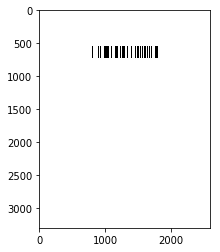

In [10]:
img = np.asarray(Image.open(curr_img_path))
imshow(img)

In [154]:
img.shape

(3300, 2592, 3)

In [155]:
factor = 4
shape = tuple(map(lambda x: x / factor, img.shape[:2]))
print shape

(825, 648)


In [156]:
img_2 = image.load_img(curr_img_path, target_size=shape, grayscale=True)
img_2 = image.img_to_array(img_2) / 255.0
print img_2.shape
img_2 = img_2.reshape([1] + list(img_2.shape))
#img_2 = preprocess_input(img_2)
print img_2.shape

(825, 648, 1)
(1, 825, 648, 1)


In [88]:
tensor = model.model.predict(img_2) #img.reshape([1]  + list(img.shape)))

In [89]:
print tensor.shape

(1, 825, 648, 2)


In [90]:
print np.sort(tensor[:,:,:,1][np.nonzero(tensor[:,:,:,1])])

[ -1.11878555e+04  -1.09813848e+04  -1.08589238e+04 ...,  -1.07869015e+01
  -1.01024065e+01  -8.65909386e+00]


In [91]:
conf = tensor[0]
print np.mean(conf), np.var(conf)
probs = np.exp(conf[:,:,1]) / (np.exp(conf[:,:,0]) + np.exp(conf[:,:,1])) # 1.0 / (1.0 + np.exp(-conf[:,:,0]))# 
print np.mean(probs), np.var(probs), np.min(probs), np.max(probs)

-917.747 95781.6
nan nan nan nan


/home/nik-kochetov/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until


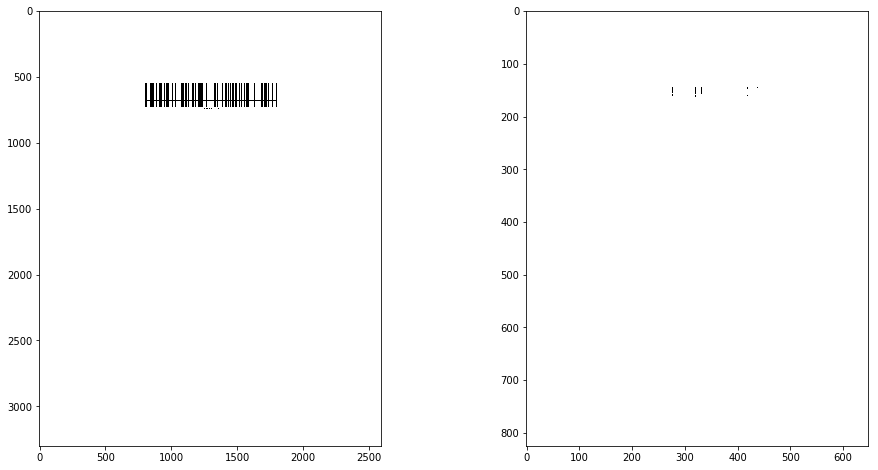

In [92]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.imshow(img)
ax2.imshow(probs, cmap='gray', vmin = np.min(probs), vmax = np.max(probs))

In [46]:
import generator
reload(generator)
from generator import Generator
ssd_generator = Generator(ROOT, model)

In [47]:
generator = ssd_generator.generate_pixels(all_annos, 64, True)

In [48]:
gen = next(generator)

next batch:
('img:', u'Empty/8217_017.3A.tif.jpg')
('window: ', Rect(466, 265, 2514, 2313))


In [36]:
print gen[0].shape
print gen[1].shape

(1, 512, 512, 1)
(1, 16, 16, 2)


In [37]:
img = gen[0][0]
conf = gen[1][0]
probs = conf[:,:,1]
print np.mean(probs), np.var(probs), np.min(probs), np.max(probs)

0.013671875 0.012508392334 0.0 1.0


In [38]:
print (np.min(img), np.max(img))

(0.0, 1.0)


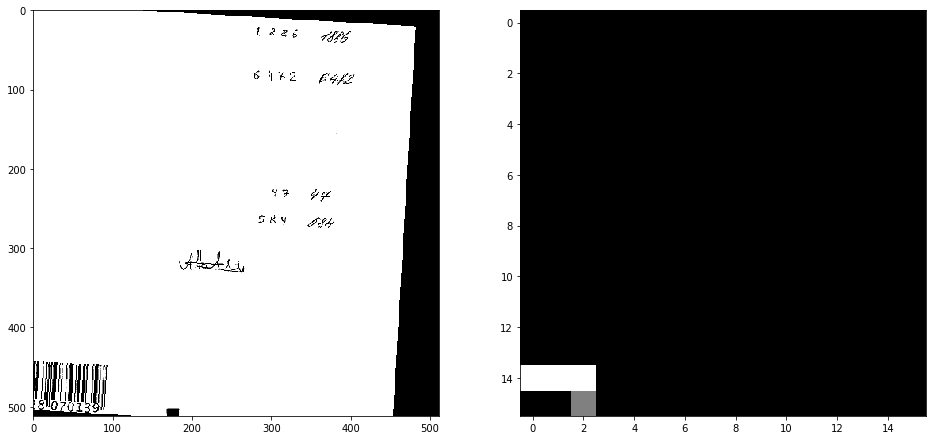

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
#show_img_from_gen(ax1, gen[0])
ax1.imshow(gen[0][0,:,:,0],cmap='gray')
ax2.imshow(probs, cmap='gray') #, vmin = np.min(probs), vmax = np.max(probs))

In [15]:
print np.min(gen[0]), np.max(gen[0])

0.0 1.0


In [51]:
tensor = model.model.predict(gen[0])

In [52]:
conf = tensor[0]
conf2 = conf[:,:,0] - conf[:,:,1]
print np.mean(conf), np.var(conf), np.min(conf), np.max(conf)
print np.mean(conf2), np.var(conf2), np.min(conf2), np.max(conf2)

-0.12758 20.9495 -6.81426 5.91227
8.69471 7.90235 -7.28296 11.6594


In [53]:
def softmax(a, b):
    mx = np.maximum(a, b)
    return np.exp(a - mx) / (np.exp(a - mx) + np.exp(b - mx))

In [54]:
conf = tensor[0]
print np.mean(conf), np.var(conf)
probs = softmax(conf[:,:,1], conf[:,:,0]) # 1.0 / (1.0 + np.exp(-conf[:,:,0])) # 
print np.mean(probs), np.var(probs), np.min(probs), np.max(probs)

-0.12758 20.9495
0.0268684 0.023624 8.63716e-06 0.999313


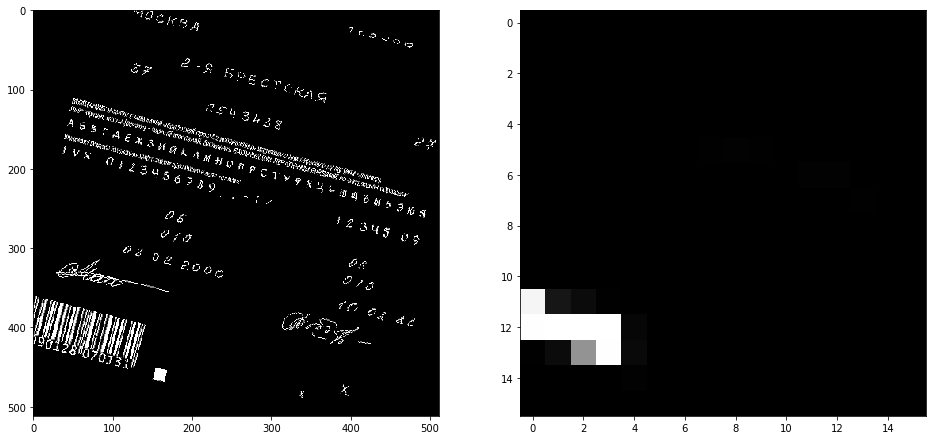

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
#show_img_from_gen(ax1, gen[0])
ax1.imshow(gen[0][0,:,:,0],cmap='gray')
ax2.imshow(probs, cmap='gray') #, vmin=np.min(probs), vmax=np.max(probs))

(10, 2)
next batch:
('img:', u'Barcodes_1d/Interleaved 2 of 5 (1)/0223.jpg')
('window: ', Rect(3947, 1146, 4459, 1658))
next batch:
('img:', u'Barcodes_1d/Code 128B/0227.jpg')
('window: ', Rect(0, 318, 2048, 2366))
next batch:
('img:', u'Empty/9418_014.3A.tif.jpg')
('window: ', Rect(205, 1140, 2253, 3188))
next batch:
('img:', u'Empty/8255_003.3A.tif.jpg')
('window: ', Rect(346, 552, 2394, 2600))
next batch:
('img:', u'Empty/8596_001.3A.tif.jpg')
('window: ', Rect(559, 929, 1583, 1953))
next batch:
('img:', u'Barcodes_1d/Wide Barcodes 1D (5)/0005.jpg')
('window: ', Rect(2954, 1694, 3466, 2206))
next batch:
('img:', u'Barcodes_1d/Wide Barcodes 1D (5)/0170.jpg')
('window: ', Rect(2991, 1663, 3503, 2175))
next batch:
('img:', u'Barcodes_1d/Interleaved 2 of 5 (2)/0374.jpg')
('window: ', Rect(134, 1500, 2182, 3548))
next batch:
('img:', u'Barcodes_1d/Interleaved 2 of 5 Check/0071.jpg')
('window: ', Rect(63, 341, 1087, 1365))
next batch:
('img:', u'Barcodes_1d/Code 128A/0145.jpg')
('window: 

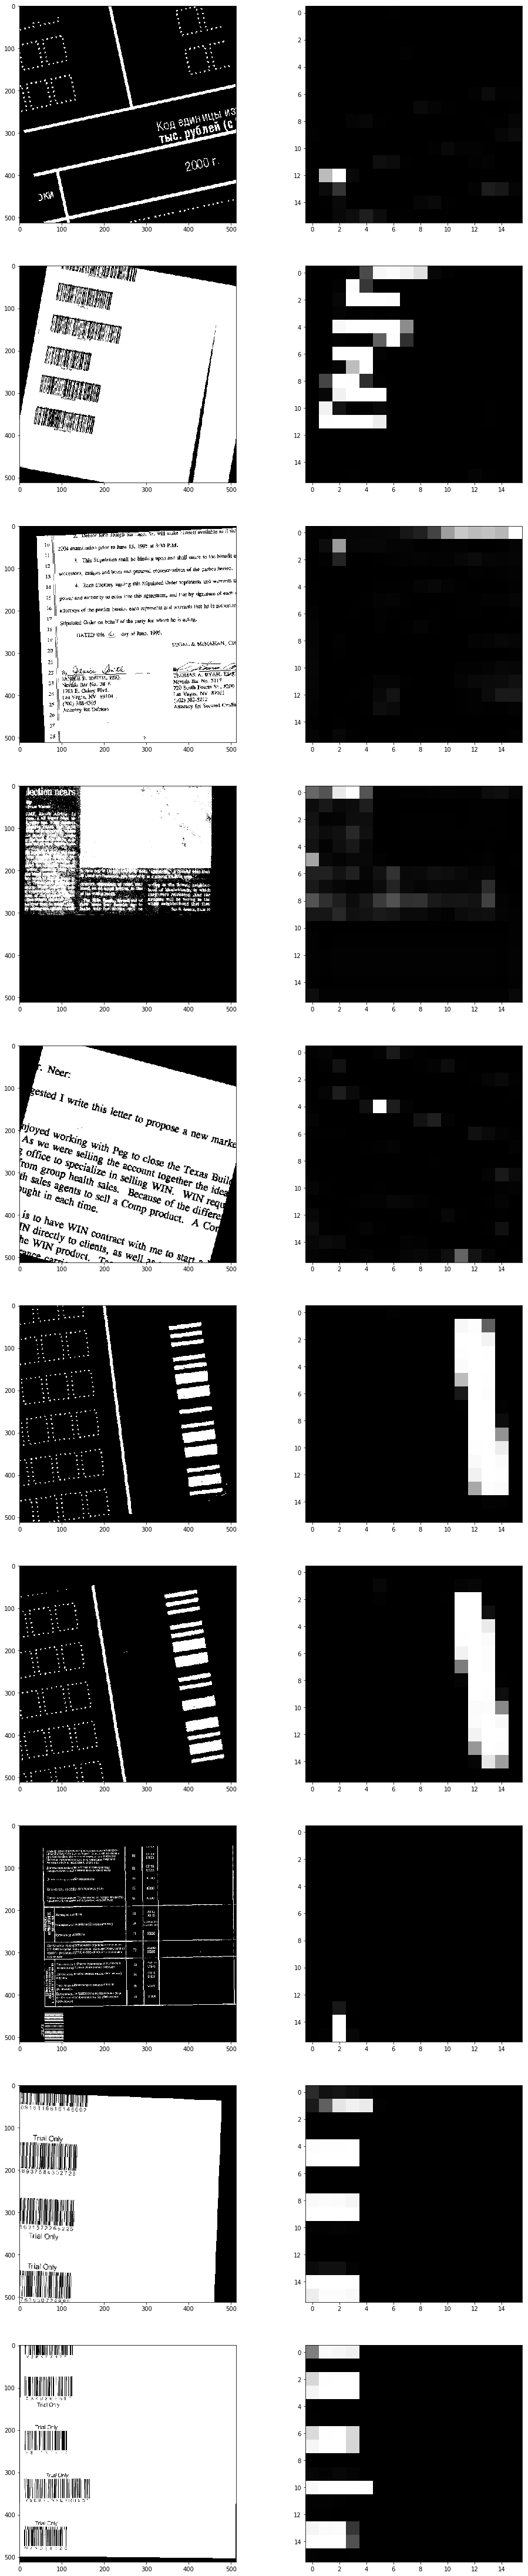

In [56]:
count = 10

fig, axes = plt.subplots(count, 2, figsize=(16, 8 * count))
print axes.shape

for i in range(count):
    gen = next(generator)
    tensor = model.model.predict(gen[0])
    conf = tensor[0]
    
    max_conf = np.max(conf)

    #probs = np.exp(conf[:,:,1] - max_conf) / (np.exp(conf[:,:,0] - max_conf) + np.exp(conf[:,:,1] - max_conf))
    #probs = 1.0 / (1.0 + np.exp(-np.exp(conf[:,:,1])))
    probs = softmax(conf[:,:,1], conf[:,:,0])
    
    axes[i][0].imshow(gen[0][0,:,:,0],cmap='gray')
    axes[i][1].imshow(probs, cmap='gray') #, vmin = np.min(probs), vmax = np.max(probs))

(10, 2)
next batch:
('img:', u'Barcodes_1d/Wide Barcodes 1D (1)/0109.jpg')
('window: ', Rect(1757, 49, 2269, 561))
next batch:
('img:', u'Barcodes_1d/Code 39 Check/0083.jpg')
('window: ', Rect(0, 234, 2048, 2282))
next batch:
('img:', u'Empty/1343_257.3A.tif.jpg')
('window: ', Rect(885, 1220, 1397, 1732))
next batch:
('img:', u'Barcodes_1d/EAN 13/0611.jpg')
('window: ', Rect(233, 1380, 2281, 3428))
next batch:
('img:', u'Empty/1676_356.3A.tif.jpg')
('window: ', Rect(1036, 1298, 1548, 1810))
next batch:
('img:', u'Barcodes_1d/Code 39.Code 32 Ideal/0112.jpg')
('window: ', Rect(0, 0, 1024, 1024))
next batch:
('img:', u'Barcodes_1d/Code 128B/0292.jpg')
('window: ', Rect(23, 159, 1047, 1183))
next batch:
('img:', u'Empty/5173_005.3A.tif.jpg')
('window: ', Rect(938, 1150, 1450, 1662))
next batch:
('img:', u'Empty/7651_053.3A.tif.jpg')
('window: ', Rect(0, 0, 8192, 8192))
next batch:
('img:', u'Barcodes_1d/EAN 13/0657.jpg')
('window: ', Rect(154, 1395, 2202, 3443))


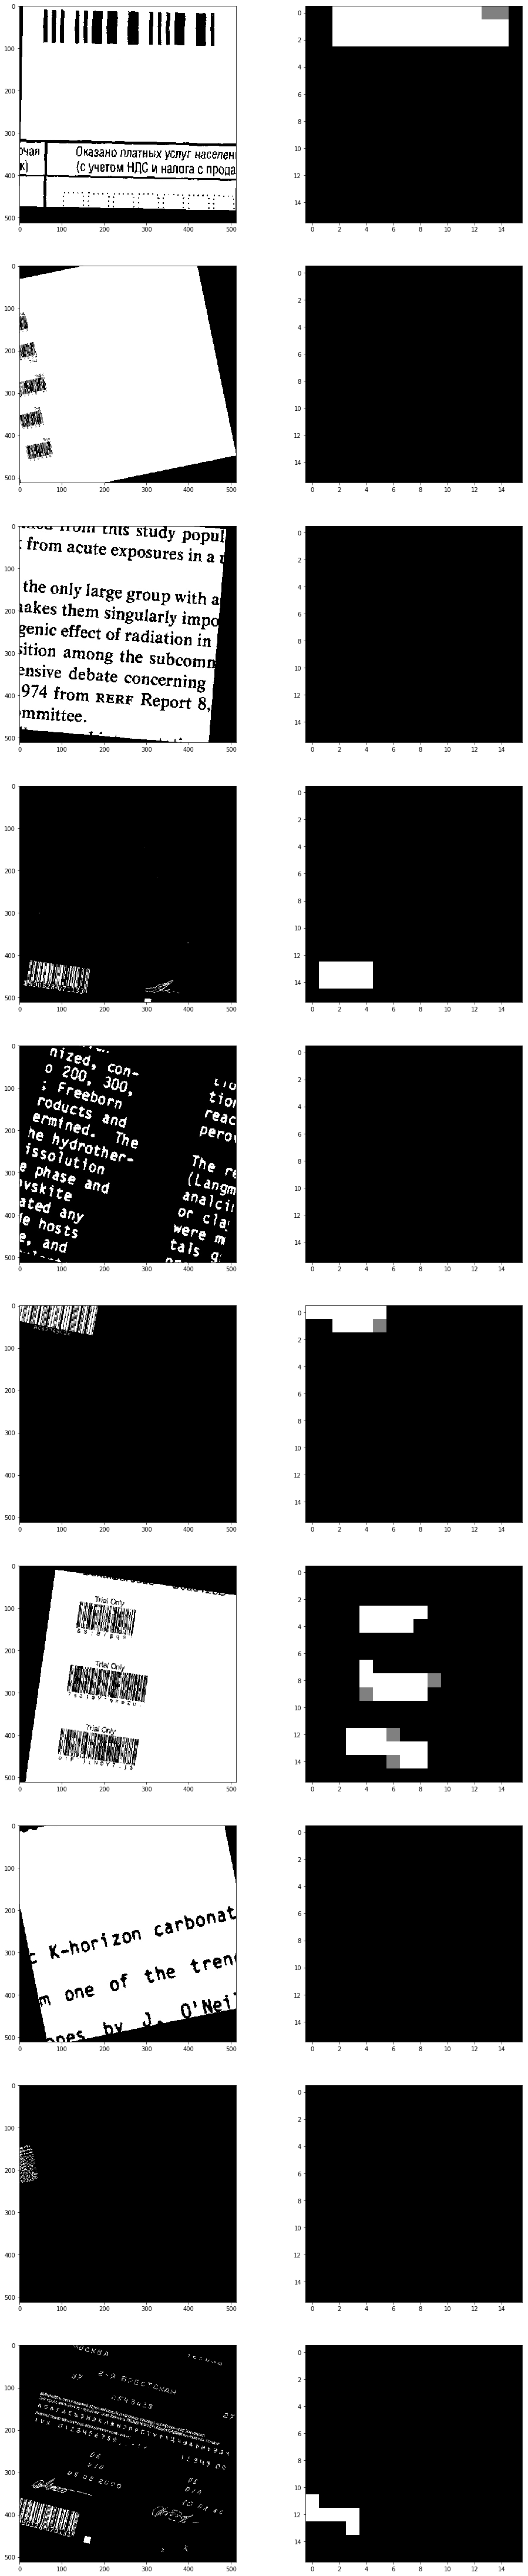

In [49]:
count = 10

fig, axes = plt.subplots(count, 2, figsize=(16, 8 * count))
print axes.shape

for i in range(count):
        gen = next(generator)
        axes[i][0].imshow(gen[0][0,:,:,0],cmap='gray')
        axes[i][1].imshow(gen[1][0,:,:,1],cmap='gray', vmin=0, vmax=1)